# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_003  H0YI30;O95390                     14.877
Sample_047  B4DYV8;Q8WZ75;Q8WZ75-2;Q8WZ75-3   14.278
Sample_090  P11279                            17.261
Sample_052  Q9H8J5                            17.666
Sample_104  O75781;O75781-2                   16.134
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups 
Sample_015  P02458;P02458-1   17.101
Sample_000  O94933            12.469
Sample_044  Q15121;Q15121-2   10.912
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.731
            A0A075B6Q5                 13.197
            A0A075B6R2                 13.814
            A0A075B6S5                 12.113
            A0A087WSY4                 13.348
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.407
            Q9UI40;Q9UI40-2            12.955
            Q9UIW2                     13.356
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.060
            Q9UP79                     12.550
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.749,15.050,16.842,19.863,13.547,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.739,19.067,...,15.528,15.576,11.758,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.524,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.520,17.705,17.039,14.675,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.065,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.173,15.345,17.084,18.708,14.249,19.433,9.214,8.124
Sample_207,15.739,16.877,15.469,16.898,12.465,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.731,...,16.012,15.178,11.803,15.050,16.842,19.863,14.078,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.009,19.067,16.188,...,15.528,15.576,12.828,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.367,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.500,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.709,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.515,15.345,17.084,18.708,14.249,19.433,12.977,11.041
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 444.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.96it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.93it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.50it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.71it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.40it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.13it/s]

100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.46it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.49it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.10it/s]

100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.21it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.00it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.55it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.37it/s]

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.33it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.71it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.03it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.46it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.06it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.96it/s]

100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.10it/s]

 30%|███       | 3/10 [00:00<00:01,  5.07it/s]

 40%|████      | 4/10 [00:00<00:01,  4.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.13it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.90it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.67it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]

100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.42it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.70it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.41it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.05it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.98it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.96it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.68it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.70it/s]

100%|██████████| 11/11 [00:02<00:00,  3.59it/s]

100%|██████████| 11/11 [00:02<00:00,  4.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.02it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.54it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.88it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.52it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.33it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.42it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.30it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.31it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.23it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.10it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.83it/s]

 31%|███       | 4/13 [00:00<00:02,  4.23it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.77it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.67it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.50it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.29it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.19it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.06it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.05it/s]

100%|██████████| 13/13 [00:03<00:00,  3.12it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.94it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.70it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.12it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.83it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.62it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.48it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.46it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.41it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.36it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.45it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.35it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.36it/s]

100%|██████████| 14/14 [00:03<00:00,  3.37it/s]

100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.09it/s]

 20%|██        | 3/15 [00:00<00:02,  4.51it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.77it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.79it/s]

 40%|████      | 6/15 [00:01<00:02,  3.64it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.42it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.44it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.33it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.41it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.45it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.49it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.40it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.052 0.015          0.788 0.321       0.122   
2             0.004 0.002      0.049 0.014          0.621 0.115       0.537   
3             0.004 0.002      0.052 0.012          0.774 0.094       0.710   
4             0.004 0.001      0.048 0.007          0.771 0.090       0.696   
5             0.004 0.003      0.055 0.017          0.809 0.079       0.772   
6             0.005 0.003      0.072 0.030          0.828 0.080       0.795   
7             0.004 0.002      0.061 0.022          0.826 0.084       0.799   
8             0.004 0.000      0.044 0.002          0.837 0.081       0.801   
9             0.004 0.000      0.043 0.004          0.831 0.076       0.799   
10            0.003 0.001      0.039 0.007          0.824 0.080       0.793   
11            0.004 0.002      0.042 0.004          0.824 0.074       0.828   
12            0.004 0.000      0.045 0.001          0.815 0.077       0.828   
13            0.004 0.000      0.045 0.001          0.812 0.075       0.832   
14            0.004 0.000      0.045 0.002          0.818 0.079       0.814   
15            0.004 0.000      0.046 0.002          0.830 0.081       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.204 0.128                  0.553 0.042        0.849   
2          0.121   0.569 0.101                  0.646 0.071        0.728   
3          0.105   0.734 0.074                  0.776 0.062        0.863   
4          0.140   0.724 0.097                  0.771 0.073        0.880   
5          0.107   0.785 0.071                  0.818 0.058        0.906   
6          0.094   0.808 0.068                  0.836 0.057        0.912   
7          0.091   0.809 0.069                  0.837 0.058        0.911   
8          0.092   0.815 0.066                  0.842 0.056        0.913   
9          0.088   0.811 0.062                  0.839 0.053        0.912   
10         0.092   0.804 0.063                  0.833 0.053        0.910   
11         0.087   0.822 0.060                  0.848 0.052        0.920   
12         0.098   0.818 0.071                  0.845 0.061        0.919   
13         0.099   0.819 0.071                  0.845 0.062        0.916   
14         0.095   0.813 0.071                  0.840 0.060        0.919   
15         0.092   0.816 0.072                  0.843 0.060        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.087        210.000 0.000  
2          0.073                  0.675 0.088        210.000 0.000  
3          0.055                  0.827 0.070        210.000 0.000  
4          0.052                  0.843 0.067        210.000 0.000  
5          0.047                  0.882 0.057        210.000 0.000  
6          0.049                  0.893 0.058        210.000 0.000  
7          0.050                  0.894 0.058        210.000 0.000  
8          0.048                  0.900 0.054        210.000 0.000  
9          0.048                  0.898 0.053        210.000 0.000  
10         0.048                  0.897 0.054        210.000 0.000  
11         0.046                  0.909 0.047        210.000 0.000  
12         0.047                  0.908 0.050        210.000 0.000  
13         0.049                  0.906 0.051        210.000 0.000  
14         0.046                  0.909 0.048        210.000 0.000  
15         0.045                  0.910 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 478.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.29it/s]

100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.91it/s]

100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.20it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.01it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.33it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.36it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.29it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.22it/s]

100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.04it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.88it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.40it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.21it/s]

100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.85it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.90it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.17it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.89it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.91it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.90it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  2.28it/s]

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.34it/s]

 30%|███       | 3/10 [00:00<00:02,  3.13it/s]

 40%|████      | 4/10 [00:01<00:01,  3.04it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.86it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.75it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.70it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.87it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.60it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.26it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.17it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.65it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.45it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.29it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.39it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.64it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.59it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.16it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.05it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.83it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.82it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.73it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.35it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.15it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.04it/s]

100%|██████████| 12/12 [00:04<00:00,  2.11it/s]

100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.51it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.77it/s]

 31%|███       | 4/13 [00:01<00:02,  3.31it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.46it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.22it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.12it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.29it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.34it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.38it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.41it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.15it/s]

100%|██████████| 13/13 [00:05<00:00,  2.10it/s]

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.73it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.58it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.57it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.50it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.73it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.20it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.03it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.94it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.03it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.03it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.02it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.07it/s]

100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.07it/s]

 20%|██        | 3/15 [00:01<00:04,  2.70it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.04it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.22it/s]

 40%|████      | 6/15 [00:02<00:04,  2.21it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.18it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.26it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.23it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.17it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.20it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.21it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.38it/s]

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

100%|██████████| 15/15 [00:06<00:00,  2.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.044 0.006          0.832 0.274       0.142   
2             0.003 0.000      0.041 0.003          0.618 0.112       0.541   
3             0.003 0.000      0.041 0.003          0.773 0.076       0.732   
4             0.004 0.002      0.044 0.009          0.786 0.083       0.782   
5             0.004 0.002      0.045 0.014          0.778 0.087       0.757   
6             0.006 0.004      0.055 0.020          0.790 0.084       0.775   
7             0.006 0.006      0.064 0.022          0.827 0.084       0.830   
8             0.006 0.005      0.061 0.023          0.815 0.082       0.806   
9             0.004 0.003      0.051 0.017          0.815 0.085       0.805   
10            0.006 0.005      0.080 0.031          0.835 0.084       0.806   
11            0.006 0.005      0.068 0.028          0.837 0.087       0.824   
12            0.006 0.008      0.063 0.023          0.846 0.086       0.813   
13            0.006 0.004      0.061 0.024          0.844 0.088       0.821   
14            0.004 0.000      0.044 0.009          0.859 0.081       0.822   
15            0.006 0.006      0.061 0.028          0.848 0.084       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.234 0.126                  0.563 0.043        0.851   
2          0.120   0.570 0.100                  0.646 0.071        0.736   
3          0.101   0.748 0.074                  0.787 0.059        0.866   
4          0.106   0.779 0.075                  0.812 0.062        0.876   
5          0.102   0.763 0.073                  0.798 0.061        0.877   
6          0.094   0.777 0.060                  0.809 0.050        0.881   
7          0.090   0.824 0.063                  0.850 0.053        0.897   
8          0.100   0.806 0.067                  0.834 0.056        0.896   
9          0.100   0.805 0.068                  0.833 0.057        0.894   
10         0.090   0.817 0.068                  0.843 0.057        0.917   
11         0.090   0.827 0.070                  0.852 0.059        0.918   
12         0.096   0.825 0.071                  0.851 0.060        0.916   
13         0.090   0.828 0.066                  0.853 0.056        0.923   
14         0.100   0.836 0.072                  0.861 0.061        0.923   
15         0.104   0.832 0.074                  0.857 0.063        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.074                  0.680 0.089        210.000 0.000  
3          0.052                  0.844 0.062        210.000 0.000  
4          0.052                  0.860 0.055        210.000 0.000  
5          0.052                  0.854 0.061        210.000 0.000  
6          0.049                  0.865 0.059        210.000 0.000  
7          0.050                  0.891 0.050        210.000 0.000  
8          0.052                  0.890 0.053        210.000 0.000  
9          0.053                  0.888 0.054        210.000 0.000  
10         0.046                  0.904 0.049        210.000 0.000  
11         0.046                  0.905 0.050        210.000 0.000  
12         0.048                  0.904 0.051        210.000 0.000  
13         0.045                  0.915 0.046        210.000 0.000  
14         0.045                  0.912 0.048        210.000 0.000  
15         0.047                  0.910 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 974.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.48it/s]

100%|██████████| 3/3 [00:00<00:00, 14.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.73it/s]

100%|██████████| 4/4 [00:00<00:00, 14.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.82it/s]

100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 13.65it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.58it/s]

100%|██████████| 6/6 [00:00<00:00, 10.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.84it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.72it/s]

100%|██████████| 7/7 [00:00<00:00, 11.27it/s]

100%|██████████| 7/7 [00:00<00:00, 12.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.69it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.79it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.49it/s]

100%|██████████| 8/8 [00:00<00:00, 12.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.72it/s]

 44%|████▍     | 4/9 [00:00<00:00, 15.02it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.69it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.68it/s]

100%|██████████| 9/9 [00:00<00:00, 12.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.01it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.53it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.41it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.45it/s]

100%|██████████| 10/10 [00:00<00:00, 10.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.01it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.82it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.80it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.55it/s]

100%|██████████| 11/11 [00:00<00:00, 13.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.57it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.48it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.64it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.55it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.74it/s]

100%|██████████| 12/12 [00:01<00:00, 10.01it/s]

100%|██████████| 12/12 [00:01<00:00, 10.25it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.87it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.38it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.25it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.10it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.46it/s]

100%|██████████| 13/13 [00:01<00:00, 10.01it/s]

100%|██████████| 13/13 [00:01<00:00, 10.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.65it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.10it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.55it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.86it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.68it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.80it/s]

100%|██████████| 14/14 [00:01<00:00, 12.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.51it/s]

 40%|████      | 6/15 [00:00<00:00, 13.21it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.62it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.65it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.58it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.00it/s]

100%|██████████| 15/15 [00:01<00:00, 12.34it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.065 0.028          0.000 0.000       0.000   
2             0.004 0.003      0.050 0.014          0.629 0.123       0.435   
3             0.005 0.004      0.075 0.029          0.611 0.123       0.423   
4             0.005 0.004      0.066 0.024          0.626 0.120       0.466   
5             0.005 0.004      0.073 0.029          0.623 0.101       0.494   
6             0.004 0.001      0.050 0.014          0.635 0.113       0.522   
7             0.007 0.007      0.077 0.036          0.646 0.120       0.509   
8             0.004 0.002      0.057 0.018          0.639 0.116       0.496   
9             0.004 0.003      0.061 0.020          0.617 0.117       0.489   
10            0.006 0.004      0.073 0.027          0.603 0.111       0.483   
11            0.005 0.004      0.058 0.028          0.606 0.109       0.509   
12            0.004 0.002      0.051 0.016          0.592 0.108       0.503   
13            0.007 0.006      0.078 0.029          0.628 0.111       0.582   
14            0.007 0.006      0.077 0.037          0.634 0.107       0.597   
15            0.005 0.003      0.061 0.020          0.634 0.110       0.621   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.700   
2          0.121   0.505 0.106                  0.621 0.068        0.691   
3          0.111   0.494 0.100                  0.611 0.069        0.695   
4          0.128   0.526 0.111                  0.630 0.075        0.708   
5          0.109   0.545 0.091                  0.636 0.066        0.707   
6          0.093   0.569 0.088                  0.649 0.073        0.705   
7          0.104   0.564 0.098                  0.650 0.077        0.721   
8          0.101   0.552 0.089                  0.642 0.068        0.719   
9          0.100   0.540 0.092                  0.631 0.070        0.706   
10         0.100   0.532 0.092                  0.623 0.069        0.702   
11         0.108   0.547 0.089                  0.631 0.068        0.700   
12         0.110   0.537 0.089                  0.622 0.067        0.694   
13         0.112   0.599 0.093                  0.662 0.076        0.723   
14         0.118   0.608 0.093                  0.670 0.072        0.733   
15         0.109   0.621 0.088                  0.675 0.074        0.741   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.678 0.076        210.000 0.000  
2          0.081                  0.627 0.092        210.000 0.000  
3          0.078                  0.624 0.089        210.000 0.000  
4          0.072                  0.652 0.090        210.000 0.000  
5          0.073                  0.654 0.093        210.000 0.000  
6          0.081                  0.659 0.097        210.000 0.000  
7          0.090                  0.664 0.102        210.000 0.000  
8          0.086                  0.661 0.097        210.000 0.000  
9          0.080                  0.650 0.096        210.000 0.000  
10         0.080                  0.647 0.096        210.000 0.000  
11         0.080                  0.642 0.097        210.000 0.000  
12         0.079                  0.635 0.096        210.000 0.000  
13         0.079                  0.660 0.096        210.000 0.000  
14         0.081                  0.671 0.107        210.000 0.000  
15         0.076                  0.693 0.101 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,7,14
score_time,6,10,13
test_precision,8,14,7
test_recall,13,7,15
test_f1,11,14,15
test_balanced_accuracy,11,14,15
test_roc_auc,15,13,15
test_average_precision,15,13,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.02it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.20it/s]

 31%|███       | 4/13 [00:01<00:03,  2.98it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.89it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.80it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.76it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.70it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.23it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.02it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.87it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.85it/s]

100%|██████████| 13/13 [00:05<00:00,  2.07it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.83it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.75it/s]

 40%|████      | 6/15 [00:00<00:00, 10.83it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.04it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.88it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.46it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.26it/s]

100%|██████████| 15/15 [00:01<00:00, 11.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.15it/s]

 20%|██        | 3/15 [00:00<00:04,  2.97it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.73it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.58it/s]

 40%|████      | 6/15 [00:02<00:03,  2.63it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.28it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.08it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.06it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.02it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.17it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.33it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.32it/s]

100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


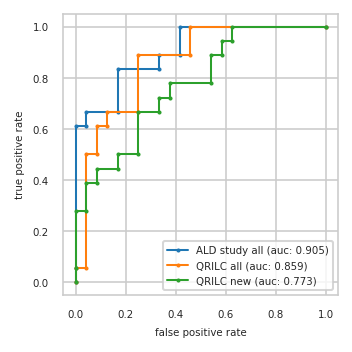

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.611     0.042 0.056     0.000 0.278
3          0.042 0.611     0.042 0.500     0.042 0.278
4          0.042 0.667     0.083 0.500     0.042 0.389
5          0.167 0.667     0.083 0.611     0.083 0.389
6          0.167 0.833     0.125 0.611     0.083 0.444
7          0.333 0.833     0.125 0.667     0.167 0.444
8          0.333 0.889     0.250 0.667     0.167 0.500
9          0.417 0.889     0.250 0.889     0.250 0.500
10         0.417 1.000     0.458 0.889     0.250 0.667
11         1.000 1.000     0.458 1.000     0.333 0.667
12           NaN   NaN     1.000 1.000     0.333 0.722
13           NaN   NaN       NaN   NaN     0.375 0.722
14           NaN   NaN       NaN   NaN     0.375 0.778
15           NaN   NaN       NaN   NaN     0.542 0.778
16           NaN   NaN       NaN   NaN     0.542 0.889
17           NaN   NaN       NaN   NaN     0.583 0.889
18           NaN   NaN       NaN   NaN     0.583 0.944
19           NaN   NaN       NaN   NaN     0.625 0.944
20           NaN   NaN       NaN   NaN     0.625 1.000
21           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q8NBI6,P60709;P63261,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,P60709;P63261,P10636-2;P10636-6,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
3,P04075,A0A0A0MRJ7;P12259,P10644;P10644-2
4,P14174,P14174,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
5,P61981,P61981,D3YTG3;H0Y897;Q7Z7G0;Q7Z7G0-2;Q7Z7G0-3;Q7Z7G0-4
6,P00338;P00338-3,P04075,A6H8L4;E7EUI5;P78536;P78536-2
7,Q9Y2T3;Q9Y2T3-3,P00338;P00338-3,D6R956;P09936
8,P08294,C9JF17;P05090,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


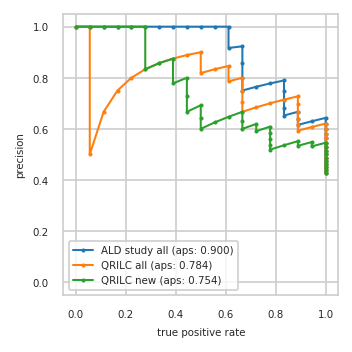

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.652 0.833     0.696 0.889     0.609 0.778
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.789 0.833     0.684 0.722     0.632 0.667
24         0.778 0.778     0.667 0.667     0.667 0.667
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.750 0.667     0.750 0.667     0.625 0.556
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.923 0.667     0.846 0.611     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.818 0.500     0.727 0.444
32         1.000 0.556     0.900 0.500     0.800 0.444
33         1.000 0.500     0.889 0.444     0.778 0.389
34         1.000 0.444     0.875 0.389     0.875 0.389
35         1.000 0.389     0.857 0.333     0.857 0.333
36         1.000 0.333     0.833 0.278     0.833 0.278
37         1.000 0.278     0.800 0.222     1.000 0.278
38         1.000 0.222     0.750 0.167     1.000 0.222
39         1.000 0.167     0.667 0.111     1.000 0.167
40         1.000 0.111     0.500 0.056     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


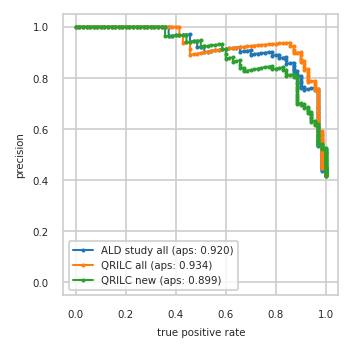

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


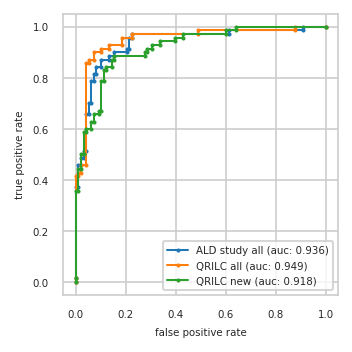

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}